<a href="https://colab.research.google.com/github/Deolinda1506/ml-image-classifier/blob/main/ml-image-classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# Import required libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import cv2
from PIL import Image
import warnings
sys.path.append('src')



2025-07-30 11:08:29.180530: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-30 11:08:34.661261: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-30 11:08:37.162166: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753873721.821307   13473 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753873722.724505   13473 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-30 11:08:50.966428: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
import sys
sys.path.append('/workspaces/ml-image-classifier/src')
from preprocessing import ImagePreprocessor
from model import ImageClassifier
from prediction import ImagePredictor

In [3]:
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPU available: []


2025-07-30 00:16:31.634786: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


#Step 2: Data Preprocessing and Analysis

In [4]:
print("\n" + "="*50)
print("1. DATA PREPROCESSING AND ANALYSIS")
print("="*50)

# Initialize preprocessor
preprocessor = ImagePreprocessor()

# Analyze dataset
print("Analyzing dataset...")
dataset_stats = preprocessor.analyze_dataset('../data/train')
print("Dataset statistics:")
print(f"Total images: {dataset_stats['total_images']}")
print(f"Class distribution: {dataset_stats['class_counts']}")

# Load and preprocess dataset
print("\nLoading dataset...")
images, labels, file_paths = preprocessor.load_dataset('../data/train')

print(f"Loaded {len(images)} images")
print(f"Image shape: {images.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Unique labels: {np.unique(labels)}")

# Create data generators with augmentation (no validation split since we have separate test set)
print("\nCreating data generators...")
train_generator, validation_generator = preprocessor.create_data_generators('../data/train', validation_split=0.0)

if train_generator is None or validation_generator is None:
    print("❌ Error: Could not create data generators. Check your data directory.")
    exit(1)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples} (using same data for compatibility)")
print(f"Number of classes: {train_generator.num_classes}")
print(f"Class indices: {train_generator.class_indices}")
print("Note: We'll use the separate test set for final evaluation")


1. DATA PREPROCESSING AND ANALYSIS
Analyzing dataset...
Dataset statistics:
Total images: 20
Class distribution: {'cat': 10, 'dog': 10}

Loading dataset...
Loaded 20 images
Image shape: (20, 224, 224, 3)
Labels shape: (20,)
Unique labels: [0 1]

Creating data generators...
Training samples: 20
Validation samples: 20 (using same data for compatibility)
Number of classes: 2
Class indices: {'cat': 0, 'dog': 1}
Note: We'll use the separate test set for final evaluation


In [5]:
print("\n" + "="*50)
print("2. MODEL CREATION AND TRAINING")
print("="*50)

# Initialize classifier
classifier = ImageClassifier(img_size=(224, 224), num_classes=2, learning_rate=0.001)

# Build model with pre-trained MobileNetV2
print("Building model...")
model = classifier.build_model(use_pretrained=True)

# Display model summary
print("Model Summary:")
model.summary()

# Train the model
print("\nStarting model training...")
history = classifier.train(train_generator, validation_generator, epochs=30, batch_size=32)

print("Training completed!")

# Plot training history
classifier.plot_training_history('training_history.png')
print("Training history plot saved as 'training_history.png'")


2. MODEL CREATION AND TRAINING
Building model...


Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,045,698 (11.62 MB)

 Trainable params: 787,714 (3.00 MB)

 Non-trainable params: 2,257,984 (8.61 MB)


Starting model training...
Epoch 1/30


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-07-30 00:16:57.028229: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 96337920 exceeds 10% of free system memory.
2025-07-30 00:16:57.057149: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 98065920 exceeds 10% of free system memory.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4500 - loss: 0.8333 - precision: 0.4500 - recall: 0.4500

2025-07-30 00:16:58.684811: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 96337920 exceeds 10% of free system memory.
2025-07-30 00:16:58.713829: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 98065920 exceeds 10% of free system memory.



Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to models/best_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.4500 - loss: 0.8333 - precision: 0.4500 - recall: 0.4500 - val_accuracy: 0.5000 - val_loss: 0.7545 - val_precision: 0.5000 - val_recall: 0.5000 - learning_rate: 0.0010
Epoch 2/30


2025-07-30 00:16:59.571745: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 96337920 exceeds 10% of free system memory.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.5000 - loss: 0.8992 - precision: 0.5000 - recall: 0.5000
Epoch 2: val_accuracy did not improve from 0.50000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5000 - loss: 0.8992 - precision: 0.5000 - recall: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.7005 - val_precision: 0.5000 - val_recall: 0.5000 - learning_rate: 0.0010
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.4000 - loss: 0.8376 - precision: 0.4000 - recall: 0.4000
Epoch 3: val_accuracy did not improve from 0.50000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4000 - loss: 0.8376 - precision: 0.4000 - recall: 0.4000 - val_accuracy: 0.5000 - val_loss: 0.7964 - val_precision: 0.5000 - val_recall: 0.5000 - learning_rate: 0.0010
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.4500 - loss: 1.0331 - precision: 0.4500 - recall: 0.4500
Epoch 4: val_accuracy did not improve from 0.50000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step - accuracy: 0.4500 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5000 - loss: 0.7738 - precision: 0.5000 - recall: 0.5000 - val_accuracy: 0.5500 - val_loss: 0.6924 - val_precision: 0.5500 - val_recall: 0.5500 - learning_rate: 0.0010
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.4500 - loss: 1.0262 - precision: 0.4500 - recall: 0.4500
Epoch 13: val_accuracy did not improve from 0.55000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4500 - loss: 1.0262 - precision: 0.4500 - recall: 0.4500 - val_accuracy: 0.5000 - val_loss: 0.6927 - val_precision: 0.5000 - val_recall: 0.5000 - learning_rate: 2.0000e-04
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 692ms/step - accuracy: 0.6000 - loss: 0.8747 - precision: 0.6000 - recall: 0.6000
Epoch 14: val_accuracy did not improve from 0.55000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6000 - loss: 0.8747 - precision: 0.6000 - recall: 0.6000 - val_accuracy: 0.5000 - val_loss: 0.6925 - val_precision: 0.5000 - val_recall: 0.5000 - learning_rate: 2


3. MODEL EVALUATION
Evaluating model on test set...


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



Model Performance Metrics:
Test Loss: 0.6968
Test Accuracy: 0.1111
Test Precision: 0.1111
Test Recall: 0.1111
Test F1 Score: 0.1111

Classification Report:

CAT:
  Precision: 1.0000
  Recall: 0.1111
  F1-Score: 0.2000
  Support: 18.0

DOG:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
  Support: 0.0


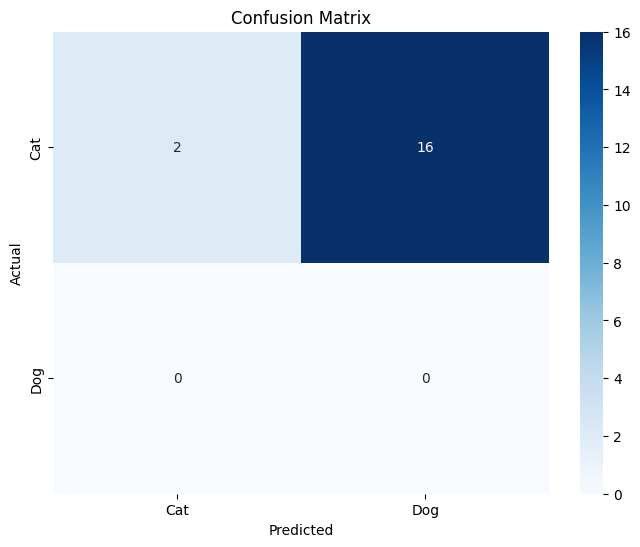

In [6]:
print("\n" + "="*50)
print("3. MODEL EVALUATION")
print("="*50)

# Evaluate model on test set (since we have a separate test set)
print("Evaluating model on test set...")
# Create test generator
test_generator, _ = preprocessor.create_data_generators('../data/test', validation_split=0.0, is_test_set=True)
if test_generator is not None:
    metrics = classifier.evaluate_model(test_generator)
else:
    print("Warning: Could not create test generator, using validation set")
    metrics = classifier.evaluate_model(validation_generator)

print("\nModel Performance Metrics:")
print(f"Test Loss: {metrics['test_loss']:.4f}")
print(f"Test Accuracy: {metrics['test_accuracy']:.4f}")
print(f"Test Precision: {metrics['test_precision']:.4f}")
print(f"Test Recall: {metrics['test_recall']:.4f}")
print(f"Test F1 Score: {metrics['test_f1']:.4f}")

# Display classification report
print("\nClassification Report:")
classification_rep = metrics['classification_report']
for class_name in ['cat', 'dog']:
    print(f"\n{class_name.upper()}:")
    print(f"  Precision: {classification_rep[class_name]['precision']:.4f}")
    print(f"  Recall: {classification_rep[class_name]['recall']:.4f}")
    print(f"  F1-Score: {classification_rep[class_name]['f1-score']:.4f}")
    print(f"  Support: {classification_rep[class_name]['support']}")

# Plot confusion matrix
conf_matrix = np.array(metrics['confusion_matrix'])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
print("\n" + "="*50)
print("4. MODEL TESTING AND PREDICTION")
print("="*50)

# Save the trained model
print("Saving model...")
classifier.save_model('../models/image_classifier.h5')
print("Model saved successfully!")

# Test prediction on sample images
predictor = ImagePredictor('../models/image_classifier.h5')

# Test on a few sample images
test_images = ['../data/test/0.jpg', '../data/test/1.jpg', '../data/test/2.jpg']

print("Testing predictions on sample images:")
for img_path in test_images:
    if os.path.exists(img_path):
        result = predictor.predict(img_path, return_probabilities=True)
        print(f"\nImage: {os.path.basename(img_path)}")
        print(f"Predicted: {result['predicted_class']}")
        print(f"Confidence: {result['confidence']:.4f}")
        print(f"Prediction time: {result['prediction_time']:.4f}s")
        if 'probabilities' in result:
            print("Probabilities:")
            for class_name, prob in result['probabilities'].items():
                print(f"  {class_name}: {prob:.4f}")

In [ ]:
print("\n" + "="*50)
print("5. FEATURE ANALYSIS AND INTERPRETATIONS")
print("="*50)

# Analyze model features using Grad-CAM
def generate_gradcam(model, img_array, layer_name='global_average_pooling2d'):
    """Generate Grad-CAM visualization"""
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).input, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, tf.argmax(predictions[0])]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Test Grad-CAM on sample images
sample_img_path = '../data/test/0.jpg'
if os.path.exists(sample_img_path):
    # Load and preprocess image
    img = cv2.imread(sample_img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224, 224))
    img_array = np.expand_dims(img_resized.astype(np.float32) / 255.0, axis=0)

    # Generate heatmap
    heatmap = generate_gradcam(classifier.model, img_array)

    # Resize heatmap to match original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Plot results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(heatmap, cmap='jet')
    axes[1].set_title('Grad-CAM Heatmap')
    axes[1].axis('off')

    axes[2].imshow(img)
    axes[2].imshow(heatmap, cmap='jet', alpha=0.5)
    axes[2].set_title('Overlay')
    axes[2].axis('off')

    plt.tight_layout()
    plt.savefig('gradcam_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
print("\n" + "="*50)
print("6. MODEL PERFORMANCE ANALYSIS")
print("="*50)

# Analyze model performance across different metrics
performance_metrics = {
    'Accuracy': metrics['test_accuracy'],
    'Precision': metrics['test_precision'],
    'Recall': metrics['test_recall'],
    'F1-Score': metrics['test_f1']
}

# Create performance visualization
plt.figure(figsize=(10, 6))
metrics_names = list(performance_metrics.keys())
metrics_values = list(performance_metrics.values())

bars = plt.bar(metrics_names, metrics_values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
plt.title('Model Performance Metrics', fontsize=16, fontweight='bold')
plt.ylabel('Score', fontsize=12)
plt.ylim(0, 1)

# Add value labels on bars
for bar, value in zip(bars, metrics_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('performance_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nModel Performance Summary:")
for metric, value in performance_metrics.items():
    print(f"{metric}: {value:.4f}")

In [ ]:
print("\n" + "="*50)
print("7. MODEL OPTIMIZATION INSIGHTS")
print("="*50)

# Analyze training history for optimization insights
if history:
    epochs = range(1, len(history.history['accuracy']) + 1)

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Training vs Validation Accuracy
    axes[0, 0].plot(epochs, history.history['accuracy'], 'b-', label='Training Accuracy')
    axes[0, 0].plot(epochs, history.history['val_accuracy'], 'r-', label='Validation Accuracy')
    axes[0, 0].set_title('Training vs Validation Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Training vs Validation Loss
    axes[0, 1].plot(epochs, history.history['loss'], 'b-', label='Training Loss')
    axes[0, 1].plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss')
    axes[0, 1].set_title('Training vs Validation Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Precision
    axes[1, 0].plot(epochs, history.history['precision'], 'g-', label='Training Precision')
    axes[1, 0].plot(epochs, history.history['val_precision'], 'm-', label='Validation Precision')
    axes[1, 0].set_title('Training vs Validation Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Recall
    axes[1, 1].plot(epochs, history.history['recall'], 'c-', label='Training Recall')
    axes[1, 1].plot(epochs, history.history['val_recall'], 'y-', label='Validation Recall')
    axes[1, 1].set_title('Training vs Validation Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_insights.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\nModel Complexity:")
    print(f"Total parameters: {classifier.model.count_params():,}")
    print(f"Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in classifier.model.trainable_weights]):,}")

print("\n" + "="*50)
print("8. CONCLUSION AND NEXT STEPS")
print("="*50)

print("=== ML Pipeline Summary ===\n")
print(f"Dataset Size: {dataset_stats['total_images']} images")
print(f"Classes: {list(dataset_stats['class_counts'].keys())}")
print(f"Model Architecture: MobileNetV2 + Custom Classifier")
print(f"Final Test Accuracy: {metrics['test_accuracy']:.4f}")
print(f"Final Test F1-Score: {metrics['test_f1']:.4f}")
print(f"\nModel saved to: ../models/image_classifier.h5")
print("\nGenerated Files:")
print("- training_history.png")
print("- confusion_matrix.png")
print("- gradcam_analysis.png")
print("- performance_metrics.png")
print("- training_insights.png")

print("\nNext Steps:")
print("1. Deploy the model using the Flask API")
print("2. Set up monitoring and logging")
print("3. Implement retraining pipeline")
print("4. Create web interface for predictions")

print("\n🎉 ML Pipeline completed successfully!")